In [10]:
import sys
from pathlib import Path
import time
import shap
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix

PROJ_ROOT = Path.cwd().parent
if str(PROJ_ROOT) not in sys.path:
    sys.path.append(str(PROJ_ROOT))

from credit_risk_xai.modeling.train import DEFAULT_PARAMS

from credit_risk_xai.config import FEATURE_CACHE_PATH
from credit_risk_xai.features.engineer import prepare_modeling_data

In [2]:
# Load and filter data
MIN_REVENUE_KSEK = 1_000
df = pd.read_parquet(FEATURE_CACHE_PATH)
df = df[(df["ser_aktiv"] == 1) & (df["sme_category"].isin(["Small", "Medium"]))]
X, y = prepare_modeling_data(df)

print(f"Features: {X.shape[1]} | Samples: {len(X):,}")
print(f"Target distribution:\n{y.value_counts()}")
print(f"Imbalance: {(y==0).sum()/(y==1).sum():.1f}:1")

Features: 107 | Samples: 889,889
Target distribution:
target_next_year
0    875385
1     14504
Name: count, dtype: Int64
Imbalance: 60.4:1


In [3]:
from credit_risk_xai.features.engineer import prepare_modeling_data
from credit_risk_xai.modeling.train import run_lightgbm_training

df = pd.read_parquet(FEATURE_CACHE_PATH)
mask = (df.ser_aktiv == 1) & (df.sme_category.isin(["Small", "Medium"]))  # add any extra filters here
X, y = prepare_modeling_data(df.loc[mask])

results = run_lightgbm_training(
    X=X,
    y=y,
    dataset_description="ser_aktiv==1 & SME∈{Small,Medium}",  # optional note for W&B
    use_wandb=False,
    wandb_project="credit-risk-xai",
    wandb_run_name="lgbm_pre_prune2",
)

[LightGBM] [Info] Number of positive: 11603, number of negative: 700308
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24233
[LightGBM] [Info] Number of data points in the train set: 711911, number of used features: 107
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.016298 -> initscore=-4.100257
[LightGBM] [Info] Start training from score -4.100257
[50]	training's binary_logloss: 0.0353196	valid_1's binary_logloss: 0.0371123
[100]	training's binary_logloss: 0.0313749	valid_1's binary_logloss: 0.035052
[150]	training's binary_logloss: 0.0287274	valid_1's binary_logloss: 0.0345087
[200]	training's binary_logloss: 0.0266849	valid_1's binary_logloss: 0.0343322
[250]	training's binary_logloss: 0.0250719	valid_1's binary_logloss: 0.0342065
[300]	training's binary_logloss: 0.0237299	valid_1's binary_logloss: 0.0341194
[350]	training's binary_loglos

In [6]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

def plot_calibration_curve(y_true, y_pred_proba, n_bins=100, model_name="Model"):
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_true, y_pred_proba, n_bins=n_bins, strategy='quantile'
    )
    
    plt.figure(figsize=(8, 6))
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=model_name)
    plt.plot([0, 1], [0, 1], "k--", label="Perfect calibration")
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.legend()
    plt.title(f"Calibration Curve - {model_name}")
    plt.show()
    
    # ECE (Expected Calibration Error)
    ece = np.mean(np.abs(fraction_of_positives - mean_predicted_value))
    print(f"ECE: {ece:.4f}")

AUC: 0.9619
PR-AUC: 0.6855

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    175077
         1.0       0.93      0.52      0.67      2901

    accuracy                           0.99    177978
   macro avg       0.96      0.76      0.83    177978
weighted avg       0.99      0.99      0.99    177978


Confusion Matrix:
[[174972    105]
 [  1393   1508]]


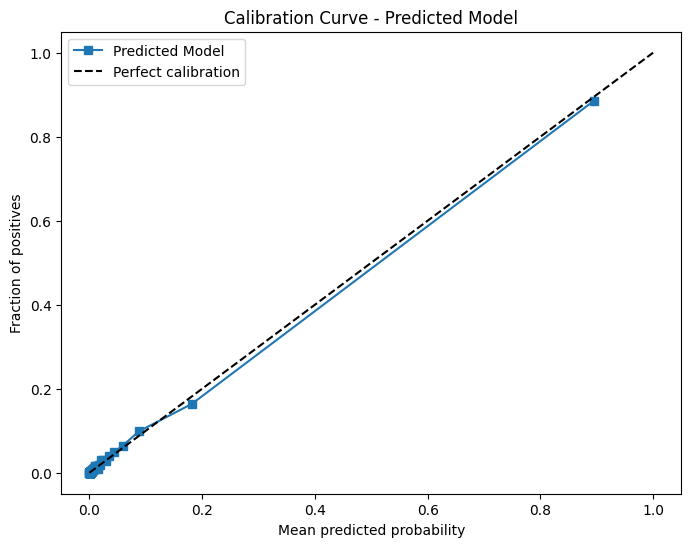

ECE: 0.0014


In [7]:
# Evaluate
model = results["model"]
X_train = results["X_train"]
X_val = results["X_val"]
y_train = results["y_train"]
y_val = results["y_val"]
y_pred_proba = results["y_val_proba"]
y_pred = (y_pred_proba >= 0.5).astype(int)

auc = roc_auc_score(y_val, y_pred_proba)
pr_auc = average_precision_score(y_val, y_pred_proba)

print(f"AUC: {auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}\n")
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))

plot_calibration_curve(y_val, y_pred_proba, model_name="Predicted Model")

Top Features (by Gain):
                         feature    importance
   years_since_last_credit_event 220258.134184
 ratio_ebit_interest_cov_yoy_pct  85568.040189
                     ny_avkegkap  72864.385179
                         ny_omsf  66225.584452
               event_count_total  33364.494119
             event_count_last_5y  28740.270117
               dso_days_yoy_diff  21677.636762
                       br10_eksu  19824.444312
           rr07_rorresul_yoy_pct  18365.259314
                 equity_to_sales  16092.338944
             ny_nettomarg_avg_2y  14282.105847
                 ny_foradlvpanst  12980.607257
           ratio_dividend_payout  12681.106575
                        dpo_days  12391.648564
    ratio_cash_liquidity_yoy_abs  12133.920963
              rr01_ntoms_yoy_pct   8414.294410
            ratio_cash_liquidity   7449.208591
            br09_tillgsu_yoy_pct   7214.698358
                     ny_skuldgrd   7057.893977
               ny_solid_yoy_diff   6

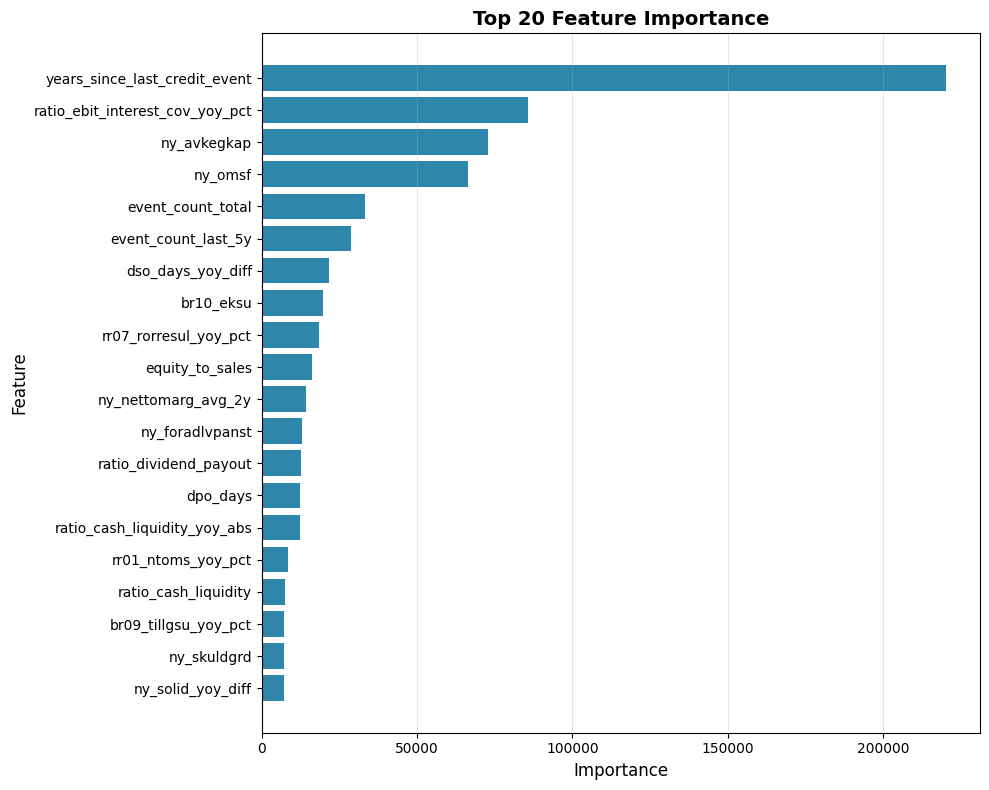


Feature Group Importance Analysis
               group  total_importance  mean_importance  feature_count
              CRISIS     282362.898420     94120.966140              3
               TREND     274648.253190      5843.579855             47
               OTHER     248814.851409      8579.822462             29
               RATIO      77610.539817      4311.696656             18
LIQUIDITY_EFFICIENCY      18231.836050      4557.959012              4
               MACRO       9629.929904      1604.988317              6


In [6]:
# Feature importance analysis
from credit_risk_xai.modeling import get_feature_importance, plot_feature_importance, analyze_feature_groups
from credit_risk_xai.config import (
    RATIO_FEATURE_NAMES, 
    LIQUIDITY_EFFICIENCY_FEATURES, 
    TREND_FEATURE_NAMES, 
    CRISIS_FEATURE_NAMES, 
    MACRO_FEATURE_NAMES
)

# 1. Get LightGBM feature importance (using gain)
importance_df = get_feature_importance(model, X_train, importance_type='gain', top_n=None)
print("Top Features (by Gain):")
print(importance_df.to_string(index=False))

# 2. Visualize feature importance
plot_feature_importance(importance_df, top_n=20, show=True)

# 3. Analyze by feature groups
feature_groups = {
    "RATIO": RATIO_FEATURE_NAMES,
    "LIQUIDITY_EFFICIENCY": LIQUIDITY_EFFICIENCY_FEATURES,
    "TREND": TREND_FEATURE_NAMES,
    "CRISIS": CRISIS_FEATURE_NAMES,
    "MACRO": MACRO_FEATURE_NAMES,
}

group_stats = analyze_feature_groups(model, X_train, feature_groups, importance_type='gain')
print("\n" + "="*80)
print("Feature Group Importance Analysis")
print("="*80)
print(group_stats.to_string(index=False))

/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Top 117 Features (by SHAP):
                         feature  mean_abs_shap
           ratio_dividend_payout       0.434005
                     ny_avkegkap       0.195513
            ratio_cash_liquidity       0.157841
                     company_age       0.149111
                       br10_eksu       0.146376
                           ny_rs       0.130417
         ratio_ebit_interest_cov       0.114859
             revenue_drawdown_5y       0.113313
                        dpo_days       0.111743
                 ny_foradlvpanst       0.110675
                    br07b_kabasu       0.101044
ratio_intragroup_financing_share       0.099516
             ny_nettomarg_avg_2y       0.099202
             bransch_sni071_konv       0.095628
              rr01_ntoms_yoy_abs       0.092526
                     knc_kncfall       0.088944
                      ny_kapomsh       0.085639
                    ny_nettomarg       0.080147
       ratio_secured_debt_assets       0.079439
   years_sin

/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


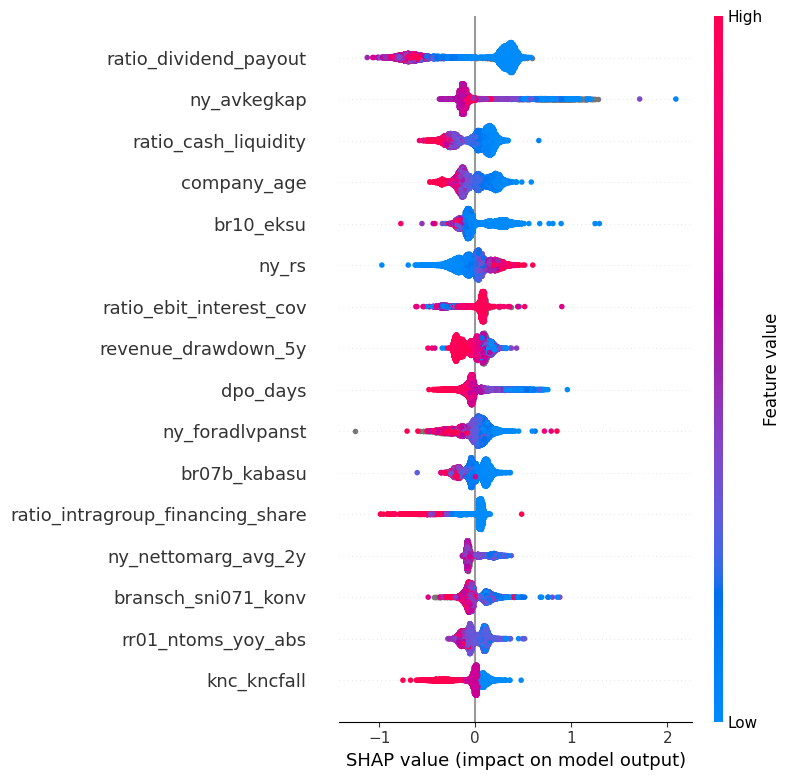

In [7]:
# SHAP analysis
from credit_risk_xai.modeling import get_shap_feature_importance, compute_shap_values
import shap

# 1. Compute SHAP-based feature importance
sample_size = min(10_000, len(X_val))
shap_importance = get_shap_feature_importance(model, X_val, max_samples=sample_size, top_n=None)

print("Top 117 Features (by SHAP):")
print(shap_importance.to_string(index=False))

# 2. Compare native importance vs SHAP
comparison = importance_df.merge(shap_importance, on='feature', how='inner')
comparison['importance_rank'] = comparison['importance'].rank(ascending=False)
comparison['shap_rank'] = comparison['mean_abs_shap'].rank(ascending=False)
comparison['rank_diff'] = abs(comparison['importance_rank'] - comparison['shap_rank'])
comparison = comparison.sort_values('rank_diff', ascending=False)

print("\n" + "="*80)
print("Features with Largest Rank Difference (Gain vs SHAP)")
print("="*80)
print(comparison[['feature', 'importance', 'importance_rank', 'mean_abs_shap', 'shap_rank', 'rank_diff']].head(15).to_string(index=False))

# 3. Generate SHAP summary plot
print(f"\nGenerating SHAP summary plot on {sample_size:,} samples...")
explainer, shap_values, X_sample = compute_shap_values(model, X_val, max_samples=sample_size)

# Handle binary classification
if isinstance(shap_values, list):
    shap_values = shap_values[1]

shap.summary_plot(shap_values, X_sample, max_display=16)

In [8]:
# Correlation analysis by financial statement source
from credit_risk_xai.modeling import (
    get_feature_correlations_by_source,
    find_high_correlations,
    plot_correlation_heatmap,
    summarize_within_group_correlations
)
from credit_risk_xai.config import FEATURE_GROUPS_BY_SOURCE

# 1. Summary of within-group correlations
print("=" * 90)
print("WITHIN-GROUP CORRELATION SUMMARY")
print("=" * 90)
group_summary = summarize_within_group_correlations(X_train, FEATURE_GROUPS_BY_SOURCE)
print(group_summary.to_string(index=False))

# 2. Compute correlations for each group
corr_by_source = get_feature_correlations_by_source(X_train, FEATURE_GROUPS_BY_SOURCE)

# 3. Find and display high correlations in each group
print("\n" + "=" * 90)
print("HIGH CORRELATIONS BY GROUP (|r| > 0.7)")
print("=" * 90)

for group_name in ["MACRO", "DERIVED_RATIOS", "WORKING_CAPITAL", "OPERATIONAL"]:
    if group_name not in corr_by_source:
        continue
    
    high_corrs = find_high_correlations(corr_by_source[group_name], threshold=0.7, top_n=50)
    
    if len(high_corrs) > 0:
        print(f"\n{group_name} - Top 50 Correlated Pairs:")
        print(high_corrs.to_string(index=False))
    else:
        print(f"\n{group_name} - No correlations above 0.7")

WITHIN-GROUP CORRELATION SUMMARY
           group  feature_count  mean_corr  median_corr  max_corr  min_corr  high_corr_pairs
  CRISIS_HISTORY              3   0.257203    -0.041736  0.901216 -0.087872                1
   BALANCE_SHEET              9   0.140891     0.009853  0.904377 -0.056832                3
INCOME_STATEMENT              8   0.114293     0.005728  0.978745 -0.000013                3
 WORKING_CAPITAL             10   0.032353    -0.000006  0.476138 -0.943930                1
  DERIVED_RATIOS             22   0.019710    -0.000017  0.971296 -0.943930               20
          TRENDS             47   0.016005     0.000073  0.998178 -0.982638               67
     OPERATIONAL              5   0.011367     0.000356  0.137555 -0.056125                0
           MACRO              6  -0.028474     0.000090  0.167604 -0.340940                0

HIGH CORRELATIONS BY GROUP (|r| > 0.7)

MACRO - No correlations above 0.7

DERIVED_RATIOS - Top 50 Correlated Pairs:
            

In [9]:
# ============================================================================
# PHASE 1: FAST FEATURE ANALYSIS - Cell 1
# Low Variance Detection + High Multicollinearity Detection
# ============================================================================

from sklearn.feature_selection import VarianceThreshold
from credit_risk_xai.modeling import find_high_correlations

print("=" * 90)
print("FEATURE PRUNING ANALYSIS - PHASE 1: FAST ANALYSIS")
print("=" * 90)

# 1. LOW VARIANCE FEATURES
print("\n1. LOW VARIANCE DETECTION")
print("-" * 90)

def identify_low_variance_features(X, threshold=0.01):
    """Identify features with near-zero variance."""
    variances = X.var()
    low_var_features = variances[variances < threshold].sort_values()
    return pd.DataFrame({
        'feature': low_var_features.index,
        'variance': low_var_features.values
    })

low_var_df = identify_low_variance_features(X_train, threshold=0.01)
print(f"Features with variance < 0.01: {len(low_var_df)}")
if len(low_var_df) > 0:
    print("\nLow variance features:")
    print(low_var_df.to_string(index=False))
else:
    print("✓ No low variance features found")

# 2. HIGH MULTICOLLINEARITY (Feature-Feature)
print("\n" + "=" * 90)
print("2. MULTICOLLINEARITY DETECTION")
print("-" * 90)

# Compute full correlation matrix
corr_matrix = X_train.corr()

# Find high correlations at multiple thresholds
high_corr_90 = find_high_correlations(corr_matrix, threshold=0.90, top_n=None)
high_corr_85 = find_high_correlations(corr_matrix, threshold=0.85, top_n=None)

print(f"Feature pairs with |corr| > 0.90: {len(high_corr_90)}")
print(f"Feature pairs with |corr| > 0.85: {len(high_corr_85)}")

if len(high_corr_85) > 0:
    print("\nMost correlated feature pairs (|r| > 0.85):")
    print(high_corr_85.to_string(index=False))
else:
    print("✓ No highly correlated pairs above 0.85")

# 3. STORE FINDINGS
features_to_investigate = {
    'low_variance': low_var_df['feature'].tolist() if len(low_var_df) > 0 else [],
    'high_multicollinearity_85': list(set(
        high_corr_85['feature_1'].tolist() + high_corr_85['feature_2'].tolist()
    )) if len(high_corr_85) > 0 else [],
    'high_multicollinearity_90': list(set(
        high_corr_90['feature_1'].tolist() + high_corr_90['feature_2'].tolist()
    )) if len(high_corr_90) > 0 else []
}

print("\n" + "=" * 90)
print("SUMMARY - Features Flagged for Investigation")
print("=" * 90)
print(f"Low variance: {len(features_to_investigate['low_variance'])}")
print(f"High multicollinearity (>0.85): {len(features_to_investigate['high_multicollinearity_85'])}")
print(f"High multicollinearity (>0.90): {len(features_to_investigate['high_multicollinearity_90'])}")

FEATURE PRUNING ANALYSIS - PHASE 1: FAST ANALYSIS

1. LOW VARIANCE DETECTION
------------------------------------------------------------------------------------------


/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


Features with variance < 0.01: 2

Low variance features:
      feature  variance
ser_nystartat       0.0
inflation_yoy  0.000228

2. MULTICOLLINEARITY DETECTION
------------------------------------------------------------------------------------------
Feature pairs with |corr| > 0.90: 46
Feature pairs with |corr| > 0.85: 104

Most correlated feature pairs (|r| > 0.85):
                 feature_1                  feature_2  correlation  abs_correlation
                   ny_omsf         rr01_ntoms_yoy_pct     1.000000         1.000000
                ny_rorkapo            ratio_nwc_sales     1.000000         1.000000
       ny_nettomarg_avg_2y        ny_nettomarg_avg_5y     0.998178         0.998178
                ny_rormarg        ratio_ebitda_margin     0.997539         0.997539
         ny_rormarg_vol_5y          ny_rormarg_avg_5y    -0.982638         0.982638
                ny_rormarg               ny_nettomarg     0.978745         0.978745
              ny_nettomarg        ratio_

In [10]:
# ============================================================================
# PHASE 1: FAST FEATURE ANALYSIS - Cell 2
# Consolidate All Analyses into Master DataFrame
# ============================================================================

from credit_risk_xai.modeling.explain import analyze_correlation_with_target


print("=" * 90)
print("CONSOLIDATING ALL FEATURE ANALYSES")
print("=" * 90)

# Merge all importance metrics we already have
target_corr = analyze_correlation_with_target(X_train, y_train, method='pearson', top_n=50)

master_df = (
    importance_df  # tree-based (from earlier cell)
    .merge(shap_importance[['feature', 'mean_abs_shap']], on='feature', how='left')
    .merge(target_corr[['feature', 'correlation']], on='feature', how='left')
)

# Rename columns for clarity
master_df = master_df.rename(columns={
    'importance': 'tree_importance',
    'mean_abs_shap': 'shap_importance',
    'correlation': 'target_corr'
})

# Add variance
master_df['variance'] = master_df['feature'].apply(lambda f: X_train[f].var())

# Add flags for each removal criterion
master_df['is_low_variance'] = master_df['feature'].isin(features_to_investigate.get('low_variance', []))
master_df['is_multicollinear_85'] = master_df['feature'].isin(features_to_investigate.get('high_multicollinearity_85', []))
master_df['is_multicollinear_90'] = master_df['feature'].isin(features_to_investigate.get('high_multicollinearity_90', []))

# Identify low importance features (bottom 20% in both SHAP and tree importance)
shap_threshold_20 = master_df['shap_importance'].quantile(0.20)
tree_threshold_20 = master_df['tree_importance'].quantile(0.20)

master_df['is_low_shap'] = master_df['shap_importance'] < shap_threshold_20
master_df['is_low_tree'] = master_df['tree_importance'] < tree_threshold_20
master_df['is_low_both'] = master_df['is_low_shap'] & master_df['is_low_tree']

# Count "red flags" for each feature
flag_cols = ['is_low_variance', 'is_multicollinear_85', 'is_low_shap', 'is_low_tree']
master_df['red_flag_count'] = master_df[flag_cols].sum(axis=1)

# Sort by red flags (most problematic first)
master_df = master_df.sort_values('red_flag_count', ascending=False)

# Display summary
print(f"\nTotal features analyzed: {len(master_df)}")
print(f"Features with 3+ red flags: {(master_df['red_flag_count'] >= 3).sum()}")
print(f"Features with 2+ red flags: {(master_df['red_flag_count'] >= 2).sum()}")
print(f"Features with 1+ red flags: {(master_df['red_flag_count'] >= 1).sum()}")

print("\n" + "-" * 90)
print("Top 20 features with most red flags:")
print("-" * 90)
display_cols = ['feature', 'tree_importance', 'shap_importance', 'target_corr', 'variance', 'red_flag_count']
print(master_df[display_cols].head(20).to_string(index=False))

# Save for manual review
master_df.to_csv('feature_analysis_master.csv', index=False)
print(f"\n✓ Saved master analysis to: feature_analysis_master.csv")

print("\n" + "=" * 90)
print("RED FLAG BREAKDOWN")
print("=" * 90)
print(f"Low variance (<0.01): {master_df['is_low_variance'].sum()}")
print(f"Multicollinear (>0.85): {master_df['is_multicollinear_85'].sum()}")
print(f"Low SHAP (bottom 20%): {master_df['is_low_shap'].sum()}")
print(f"Low tree importance (bottom 20%): {master_df['is_low_tree'].sum()}")
print(f"Low in BOTH importance metrics: {master_df['is_low_both'].sum()}")

CONSOLIDATING ALL FEATURE ANALYSES


/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2908: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:134: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/numpy/lib/_


Total features analyzed: 107
Features with 3+ red flags: 7
Features with 2+ red flags: 17
Features with 1+ red flags: 53

------------------------------------------------------------------------------------------
Top 20 features with most red flags:
------------------------------------------------------------------------------------------
                feature  tree_importance  shap_importance  target_corr     variance  red_flag_count
          ser_nystartat        51.729520         0.000100          NaN 0.000000e+00               3
      ny_rormarg_avg_5y      1504.313288         0.011218    -0.002783 1.145099e+04               3
             ny_rorkapo      1446.341951         0.008521          NaN 2.907014e+06               3
    ny_rormarg_trend_5y       877.421021         0.003125          NaN 2.016949e+03               3
  ny_nettomarg_trend_5y       859.508265         0.004284          NaN 4.617512e+03               3
      ny_rormarg_vol_3y      1498.450792         0.006962 

In [11]:
# ============================================================================
# PHASE 1: FAST FEATURE ANALYSIS - Cell 3
# Resolve Multicollinearity Pairs - Keep Feature with Higher SHAP
# ============================================================================

print("=" * 90)
print("RESOLVING MULTICOLLINEARITY PAIRS")
print("=" * 90)

def resolve_multicollinearity_pairs(corr_pairs_df, master_df, strategy='shap'):
    """
    For each highly correlated pair, keep the better feature.
    
    Args:
        corr_pairs_df: DataFrame with columns ['feature_1', 'feature_2', 'correlation']
        master_df: Master feature analysis DataFrame
        strategy: 'shap', 'tree', or 'target_corr'
    
    Returns:
        List of features to drop
    """
    if len(corr_pairs_df) == 0:
        return []
    
    features_to_drop = []
    importance_col = {
        'shap': 'shap_importance',
        'tree': 'tree_importance',
        'target_corr': 'target_corr'
    }[strategy]
    
    for idx, row in corr_pairs_df.iterrows():
        feat1, feat2 = row['feature_1'], row['feature_2']
        
        # Skip if already marked for removal
        if feat1 in features_to_drop or feat2 in features_to_drop:
            continue
        
        # Get metrics for both
        metrics1 = master_df[master_df['feature'] == feat1].iloc[0]
        metrics2 = master_df[master_df['feature'] == feat2].iloc[0]
        
        # Decision: keep feature with higher importance
        val1 = metrics1[importance_col]
        val2 = metrics2[importance_col]
        
        if pd.isna(val1):
            val1 = 0
        if pd.isna(val2):
            val2 = 0
        
        if val1 >= val2:
            features_to_drop.append(feat2)
            print(f"Drop '{feat2}' (keep '{feat1}') | {importance_col}: {val2:.6f} vs {val1:.6f} | corr: {row['correlation']:.3f}")
        else:
            features_to_drop.append(feat1)
            print(f"Drop '{feat1}' (keep '{feat2}') | {importance_col}: {val1:.6f} vs {val2:.6f} | corr: {row['correlation']:.3f}")
    
    return features_to_drop

# Resolve multicollinearity using SHAP importance (as per user preference)
print(f"\nResolving {len(high_corr_85)} highly correlated pairs (|r| > 0.85)...")
print("Strategy: Keep feature with HIGHER SHAP importance")
print("-" * 90)

multicollinearity_drops = resolve_multicollinearity_pairs(
    high_corr_85, 
    master_df, 
    strategy='shap'
)

print("\n" + "=" * 90)
print(f"✓ Resolved {len(high_corr_85)} pairs → {len(multicollinearity_drops)} features to drop")
print("=" * 90)

RESOLVING MULTICOLLINEARITY PAIRS

Resolving 104 highly correlated pairs (|r| > 0.85)...
Strategy: Keep feature with HIGHER SHAP importance
------------------------------------------------------------------------------------------
Drop 'rr01_ntoms_yoy_pct' (keep 'ny_omsf') | shap_importance: 0.017993 vs 0.039324 | corr: 1.000
Drop 'ny_rorkapo' (keep 'ratio_nwc_sales') | shap_importance: 0.008521 vs 0.039029 | corr: 1.000
Drop 'ny_nettomarg_avg_5y' (keep 'ny_nettomarg_avg_2y') | shap_importance: 0.044496 vs 0.099202 | corr: 0.998
Drop 'ratio_ebitda_margin' (keep 'ny_rormarg') | shap_importance: 0.014364 vs 0.026467 | corr: 0.998
Drop 'ny_rormarg_vol_5y' (keep 'ny_rormarg_avg_5y') | shap_importance: 0.006976 vs 0.011218 | corr: -0.983
Drop 'ny_rormarg' (keep 'ny_nettomarg') | shap_importance: 0.026467 vs 0.080147 | corr: 0.979
Drop 'dso_days' (keep 'cash_conversion_cycle') | shap_importance: 0.022790 vs 0.024515 | corr: 0.971
Drop 'ny_rormarg_trend_5y' (keep 'ny_rormarg_avg_2y') | shap_i

In [ ]:
# ============================================================================
# PHASE 2: PROGRESSIVE PRUNING - Cell 4
# Round 1: Conservative Pruning
# ============================================================================

print("=" * 90)
print("PHASE 2: PROGRESSIVE FEATURE PRUNING")
print("=" * 90)
print("\nROUND 1: CONSERVATIVE PRUNING")
print("-" * 90)
print("Removal criteria:")
print("  - Near-zero variance features")
print("  - One feature from each highly correlated pair (|r| > 0.85)")
print("  - Features with 3+ red flags")
print("-" * 90)

# Build conservative removal list
automatic_removal = master_df[master_df['red_flag_count'] >= 3]['feature'].tolist()

conservative_removal_list = list(set(
    features_to_investigate.get('low_variance', []) +
    multicollinearity_drops +
    automatic_removal
))

print(f"\nRemoval breakdown:")
print(f"  - Low variance: {len(features_to_investigate.get('low_variance', []))}")
print(f"  - Multicollinearity: {len(multicollinearity_drops)}")
print(f"  - Multiple red flags (3+): {len(automatic_removal)}")
print(f"\nTotal features to remove: {len(conservative_removal_list)}")
print(f"Features remaining: {X_train.shape[1] - len(conservative_removal_list)}")
print(f"Reduction: {100 * len(conservative_removal_list) / X_train.shape[1]:.1f}%")

# Create pruned dataset
features_conservative = [f for f in X_train.columns if f not in conservative_removal_list]
X_train_conservative = X_train[features_conservative]
X_val_conservative = X_val[features_conservative]

# Retrain model with same hyperparameters
print("\n" + "-" * 90)
print("Retraining model with conservative feature set...")
print("-" * 90)

lgbm_conservative = lgb.LGBMClassifier(**DEFAULT_PARAMS)
lgbm_conservative.fit(
    X_train_conservative, y_train,
    eval_set=[(X_val_conservative, y_val)],
    eval_metric='logloss',
    callbacks=[lgb.log_evaluation(100), lgb.early_stopping(50)]
)

# Predictions
y_pred_proba_conservative = lgbm_conservative.predict_proba(X_val_conservative)[:, 1]
y_pred_conservative = (y_pred_proba_conservative >= 0.5).astype(int)

# Evaluate
auc_conservative = roc_auc_score(y_val, y_pred_proba_conservative)
pr_auc_conservative = average_precision_score(y_val, y_pred_proba_conservative)

print("\n" + "=" * 90)
print("CONSERVATIVE MODEL PERFORMANCE")
print("=" * 90)
print(f"ROC-AUC:  {auc_conservative:.6f} (baseline: {auc:.6f}, Δ: {auc_conservative - auc:+.6f})")
print(f"PR-AUC:   {pr_auc_conservative:.6f} (baseline: {pr_auc:.6f}, Δ: {pr_auc_conservative - pr_auc:+.6f})")
print(f"\nFeatures: {len(features_conservative)} (from {X_train.shape[1]})")
print(f"Reduction: {100 * len(conservative_removal_list) / X_train.shape[1]:.1f}%")

print("\nClassification Report:")
print(classification_report(y_val, y_pred_conservative))

PHASE 2: PROGRESSIVE FEATURE PRUNING

ROUND 1: CONSERVATIVE PRUNING
------------------------------------------------------------------------------------------
Removal criteria:
  - Near-zero variance features
  - One feature from each highly correlated pair (|r| > 0.85)
  - Features with 3+ red flags
------------------------------------------------------------------------------------------

Removal breakdown:
  - Low variance: 2
  - Multicollinearity: 21
  - Multiple red flags (3+): 7

Total features to remove: 24
Features remaining: 83
Reduction: 22.4%

------------------------------------------------------------------------------------------
Retraining model with conservative feature set...
------------------------------------------------------------------------------------------
[LightGBM] [Info] Number of positive: 11603, number of negative: 700308
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063178 seconds.
You can set `force_col_wise=tru

In [13]:
# ============================================================================
# PHASE 2: PROGRESSIVE PRUNING - Cell 5
# Round 2: Moderate Pruning
# ============================================================================

print("=" * 90)
print("ROUND 2: MODERATE PRUNING")
print("-" * 90)
print("Additional removal criteria:")
print("  - Features in bottom 20% of BOTH SHAP and tree importance")
print("-" * 90)

# Add features that are low in both importance metrics
low_both_features = master_df[master_df['is_low_both']]['feature'].tolist()

moderate_removal_list = list(set(
    conservative_removal_list +
    low_both_features
))

print(f"\nAdding {len(low_both_features)} features with low importance in both metrics")
print(f"Total features to remove: {len(moderate_removal_list)}")
print(f"Features remaining: {X_train.shape[1] - len(moderate_removal_list)}")
print(f"Reduction: {100 * len(moderate_removal_list) / X_train.shape[1]:.1f}%")

# Create moderate pruned dataset
features_moderate = [f for f in X_train.columns if f not in moderate_removal_list]
X_train_moderate = X_train[features_moderate]
X_val_moderate = X_val[features_moderate]

print("\n" + "-" * 90)
print("Retraining model with moderate feature set...")
print("-" * 90)

lgbm_moderate = lgb.LGBMClassifier(**DEFAULT_PARAMS)
lgbm_moderate.fit(
    X_train_moderate, y_train,
    eval_set=[(X_val_moderate, y_val)],
    eval_metric='logloss',
    callbacks=[lgb.log_evaluation(100), lgb.early_stopping(50)]
)

# Predictions
y_pred_proba_moderate = lgbm_moderate.predict_proba(X_val_moderate)[:, 1]
y_pred_moderate = (y_pred_proba_moderate >= 0.5).astype(int)

# Evaluate
auc_moderate = roc_auc_score(y_val, y_pred_proba_moderate)
pr_auc_moderate = average_precision_score(y_val, y_pred_proba_moderate)

print("\n" + "=" * 90)
print("MODERATE MODEL PERFORMANCE")
print("=" * 90)
print(f"ROC-AUC:  {auc_moderate:.6f} (baseline: {auc:.6f}, Δ: {auc_moderate - auc:+.6f})")
print(f"PR-AUC:   {pr_auc_moderate:.6f} (baseline: {pr_auc:.6f}, Δ: {pr_auc_moderate - pr_auc:+.6f})")
print(f"\nFeatures: {len(features_moderate)} (from {X_train.shape[1]})")
print(f"Reduction: {100 * len(moderate_removal_list) / X_train.shape[1]:.1f}%")

print("\nClassification Report:")
print(classification_report(y_val, y_pred_moderate))

ROUND 2: MODERATE PRUNING
------------------------------------------------------------------------------------------
Additional removal criteria:
  - Features in bottom 20% of BOTH SHAP and tree importance
------------------------------------------------------------------------------------------

Adding 11 features with low importance in both metrics
Total features to remove: 28
Features remaining: 79
Reduction: 26.2%

------------------------------------------------------------------------------------------
Retraining model with moderate feature set...
------------------------------------------------------------------------------------------
[LightGBM] [Info] Number of positive: 11603, number of negative: 700308
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18294
[LightGBM] [Info] Number of data points in the train set: 711911, number of used

In [14]:
# ============================================================================
# PHASE 2: PROGRESSIVE PRUNING - Cell 6
# Round 3: Top-K Pruning Tests (Aggressive)
# ============================================================================

print("=" * 90)
print("ROUND 3: TOP-K FEATURE SELECTION (AGGRESSIVE)")
print("-" * 90)
print("Testing different feature set sizes by keeping only top-K features by SHAP importance")
print("-" * 90)

# Sort features by SHAP importance
shap_ranked = master_df.sort_values('shap_importance', ascending=False)

# Store results for different K values
topk_results = {}

for top_k in [60, 50, 40, 30]:
    print(f"\n{'='*90}")
    print(f"Testing TOP-{top_k} features by SHAP importance")
    print('-'*90)
    
    # Select top K features
    features_topk = shap_ranked.head(top_k)['feature'].tolist()
    
    X_train_topk = X_train[features_topk]
    X_val_topk = X_val[features_topk]
    
    # Train model (silent mode)
    lgbm_topk = lgb.LGBMClassifier(**DEFAULT_PARAMS)
    lgbm_topk.fit(
        X_train_topk, y_train,
        eval_set=[(X_val_topk, y_val)],
        eval_metric='logloss',
        callbacks=[lgb.log_evaluation(0), lgb.early_stopping(50)]  # Silent
    )
    
    # Evaluate
    y_pred_proba_topk = lgbm_topk.predict_proba(X_val_topk)[:, 1]
    y_pred_topk = (y_pred_proba_topk >= 0.5).astype(int)
    
    auc_topk = roc_auc_score(y_val, y_pred_proba_topk)
    pr_auc_topk = average_precision_score(y_val, y_pred_proba_topk)
    
    # Store results
    topk_results[f'top_{top_k}'] = {
        'model': lgbm_topk,
        'features': features_topk,
        'X_train': X_train_topk,
        'X_val': X_val_topk,
        'y_pred_proba': y_pred_proba_topk,
        'y_pred': y_pred_topk,
        'auc': auc_topk,
        'pr_auc': pr_auc_topk,
        'num_features': top_k
    }
    
    print(f"ROC-AUC:  {auc_topk:.6f} (Δ from baseline: {auc_topk - auc:+.6f})")
    print(f"PR-AUC:   {pr_auc_topk:.6f} (Δ from baseline: {pr_auc_topk - pr_auc:+.6f})")
    print(f"Features: {top_k} ({100 * (X_train.shape[1] - top_k) / X_train.shape[1]:.1f}% reduction)")

print("\n" + "=" * 90)
print("✓ Top-K testing complete")
print("=" * 90)

ROUND 3: TOP-K FEATURE SELECTION (AGGRESSIVE)
------------------------------------------------------------------------------------------
Testing different feature set sizes by keeping only top-K features by SHAP importance
------------------------------------------------------------------------------------------

Testing TOP-60 features by SHAP importance
------------------------------------------------------------------------------------------
[LightGBM] [Info] Number of positive: 11603, number of negative: 700308
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13687
[LightGBM] [Info] Number of data points in the train set: 711911, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.016298 -> initscore=-4.100257
[LightGBM] [Info] Start training from score -4.100257
Training until validation scores don't improve for 50 

COMPREHENSIVE PERFORMANCE COMPARISON

               Approach  Num_Features  ROC_AUC   PR_AUC  Feature_Reduction_%  AUC_Delta  PR_AUC_Delta
Baseline (105 features)           107 0.961916 0.685508             0.000000   0.000000      0.000000
   Conservative Pruning            83 0.960941 0.682507            22.429907  -0.000975     -0.003002
       Moderate Pruning            79 0.961158 0.685321            26.168224  -0.000758     -0.000187
            Top-50 SHAP            50 0.960517 0.680848            53.271028  -0.001398     -0.004661
            Top-40 SHAP            40 0.959877 0.679103            62.616822  -0.002038     -0.006405
            Top-30 SHAP            30 0.958795 0.671722            71.962617  -0.003121     -0.013787


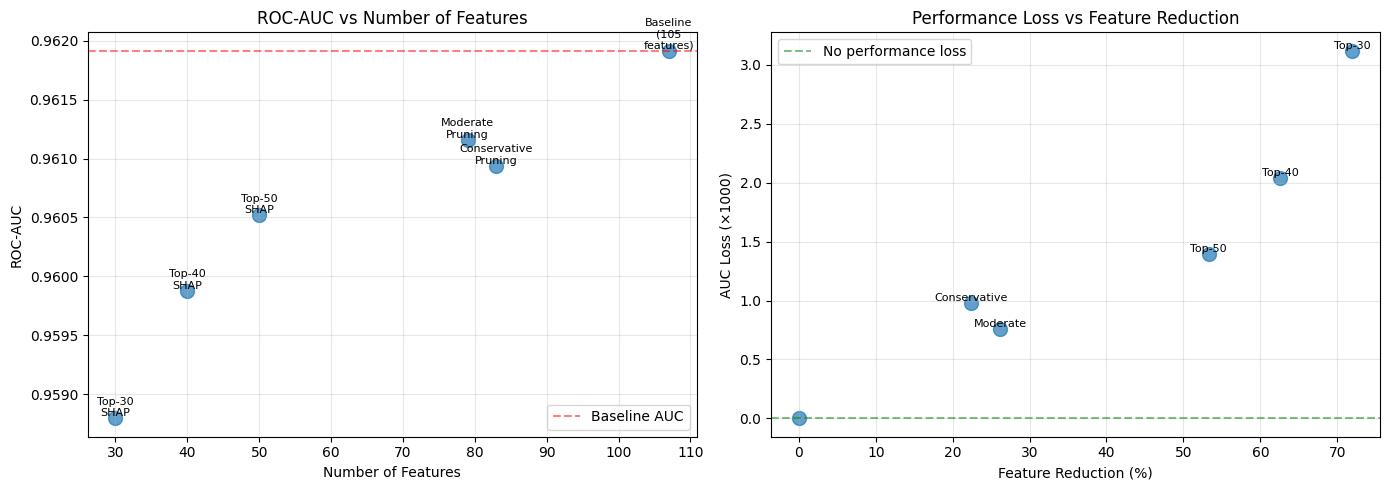


RECOMMENDATION & DECISION GUIDANCE

✓ Best AUC: Baseline (105 features) (0.961916)
✓ Best balance (>20% reduction): Top-50 SHAP
  - 50 features (53.3% reduction)
  - AUC: 0.960517 (Δ: -0.001398)

------------------------------------------------------------------------------------------
Next step: Choose your preferred approach and run the final analysis cells
Recommendation: Conservative or Moderate if AUC loss < 0.001
               Top-K if you need maximum interpretability and AUC loss is acceptable


In [15]:
# ============================================================================
# PHASE 2: PROGRESSIVE PRUNING - Cell 7
# Performance Comparison & Decision Point
# ============================================================================

print("=" * 90)
print("COMPREHENSIVE PERFORMANCE COMPARISON")
print("=" * 90)

# Compile all results
comparison_data = {
    'Approach': [
        'Baseline (105 features)',
        'Conservative Pruning',
        'Moderate Pruning',
        'Top-50 SHAP',
        'Top-40 SHAP',
        'Top-30 SHAP'
    ],
    'Num_Features': [
        X_train.shape[1],
        len(features_conservative),
        len(features_moderate),
        50, 40, 30
    ],
    'ROC_AUC': [
        auc,
        auc_conservative,
        auc_moderate,
        topk_results['top_50']['auc'],
        topk_results['top_40']['auc'],
        topk_results['top_30']['auc']
    ],
    'PR_AUC': [
        pr_auc,
        pr_auc_conservative,
        pr_auc_moderate,
        topk_results['top_50']['pr_auc'],
        topk_results['top_40']['pr_auc'],
        topk_results['top_30']['pr_auc']
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df['Feature_Reduction_%'] = 100 * (X_train.shape[1] - comparison_df['Num_Features']) / X_train.shape[1]
comparison_df['AUC_Delta'] = comparison_df['ROC_AUC'] - auc
comparison_df['PR_AUC_Delta'] = comparison_df['PR_AUC'] - pr_auc

print("\n" + comparison_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: AUC vs Feature Count
axes[0].scatter(comparison_df['Num_Features'], comparison_df['ROC_AUC'], s=100, alpha=0.7)
for idx, row in comparison_df.iterrows():
    axes[0].annotate(
        row['Approach'].replace(' ', '\n'), 
        (row['Num_Features'], row['ROC_AUC']),
        fontsize=8, ha='center', va='bottom'
    )
axes[0].axhline(y=auc, color='red', linestyle='--', alpha=0.5, label='Baseline AUC')
axes[0].set_xlabel('Number of Features')
axes[0].set_ylabel('ROC-AUC')
axes[0].set_title('ROC-AUC vs Number of Features')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Plot 2: Feature Reduction vs Performance Loss
axes[1].scatter(comparison_df['Feature_Reduction_%'], -comparison_df['AUC_Delta'] * 1000, s=100, alpha=0.7)
for idx, row in comparison_df.iterrows():
    if idx > 0:  # Skip baseline
        axes[1].annotate(
            row['Approach'].split()[0], 
            (row['Feature_Reduction_%'], -row['AUC_Delta'] * 1000),
            fontsize=8, ha='center', va='bottom'
        )
axes[1].axhline(y=0, color='green', linestyle='--', alpha=0.5, label='No performance loss')
axes[1].set_xlabel('Feature Reduction (%)')
axes[1].set_ylabel('AUC Loss (×1000)')
axes[1].set_title('Performance Loss vs Feature Reduction')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

# Decision guidance
print("\n" + "=" * 90)
print("RECOMMENDATION & DECISION GUIDANCE")
print("=" * 90)

# Find best tradeoffs
best_auc = comparison_df.iloc[comparison_df['ROC_AUC'].idxmax()]
best_reduction = comparison_df[comparison_df['Feature_Reduction_%'] > 20].iloc[
    comparison_df[comparison_df['Feature_Reduction_%'] > 20]['AUC_Delta'].idxmax()
]

print(f"\n✓ Best AUC: {best_auc['Approach']} ({best_auc['ROC_AUC']:.6f})")
print(f"✓ Best balance (>20% reduction): {best_reduction['Approach']}")
print(f"  - {best_reduction['Num_Features']} features ({best_reduction['Feature_Reduction_%']:.1f}% reduction)")
print(f"  - AUC: {best_reduction['ROC_AUC']:.6f} (Δ: {best_reduction['AUC_Delta']:+.6f})")

print("\n" + "-" * 90)
print("Next step: Choose your preferred approach and run the final analysis cells")
print("Recommendation: Conservative or Moderate if AUC loss < 0.001")
print("               Top-K if you need maximum interpretability and AUC loss is acceptable")
print("=" * 90)

In [ ]:
# ============================================================================
# PHASE 3: FINAL MODEL ANALYSIS - Cell 8
# Select Final Model & Re-analyze Feature Set
# ============================================================================

print("=" * 90)
print("PHASE 3: FINAL MODEL SELECTION & ANALYSIS")
print("=" * 90)

# USER DECISION: Choose which model to use as final
# Options: 'conservative', 'moderate', 'top_50', 'top_40', 'top_30'
FINAL_MODEL_CHOICE = 'conservative'  # ← CHANGE THIS based on comparison results

print(f"\nSelected approach: {FINAL_MODEL_CHOICE.upper()}")
print("-" * 90)

# Map choice to results
model_map = {
    'conservative': {
        'model': lgbm_conservative,
        'features': features_conservative,
        'X_train': X_train_conservative,
        'X_val': X_val_conservative,
        'y_pred_proba': y_pred_proba_conservative,
        'removal_list': conservative_removal_list,
        'auc': auc_conservative,
        'pr_auc': pr_auc_conservative
    },
    'moderate': {
        'model': lgbm_moderate,
        'features': features_moderate,
        'X_train': X_train_moderate,
        'X_val': X_val_moderate,
        'y_pred_proba': y_pred_proba_moderate,
        'removal_list': moderate_removal_list,
        'auc': auc_moderate,
        'pr_auc': pr_auc_moderate
    },
    'top_50': topk_results['top_50'],
    'top_40': topk_results['top_40'],
    'top_30': topk_results['top_30']
}

final_model_data = model_map[FINAL_MODEL_CHOICE]
final_model = final_model_data['model']
final_features = final_model_data['features']
final_X_train = final_model_data['X_train']
final_X_val = final_model_data['X_val']
final_y_pred_proba = final_model_data['y_pred_proba']

print(f"Final feature count: {len(final_features)}")
print(f"Reduction: {100 * (X_train.shape[1] - len(final_features)) / X_train.shape[1]:.1f}%")
print(f"ROC-AUC: {final_model_data['auc']:.6f}")
print(f"PR-AUC: {final_model_data['pr_auc']:.6f}")

# 1. FEATURE IMPORTANCE FOR FINAL MODEL
print("\n" + "=" * 90)
print("FEATURE IMPORTANCE - FINAL MODEL")
print("=" * 90)

final_importance_df = pd.DataFrame({
    'feature': final_model.feature_name_,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 30 features:")
print(final_importance_df.head(30).to_string(index=False))

# Plot top features
from credit_risk_xai.modeling import plot_feature_importance
plot_feature_importance(final_importance_df, top_n=25, title=f"Top 25 Features - {FINAL_MODEL_CHOICE.upper()} Model")

# Importance concentration
top10_importance = final_importance_df.head(10)['importance'].sum() / final_importance_df['importance'].sum()
top20_importance = final_importance_df.head(20)['importance'].sum() / final_importance_df['importance'].sum()

print(f"\n✓ Top 10 features account for {top10_importance * 100:.1f}% of total importance")
print(f"✓ Top 20 features account for {top20_importance * 100:.1f}% of total importance")

# 2. RE-CHECK CORRELATION ANALYSIS
print("\n" + "=" * 90)
print("CORRELATION CHECK - FINAL MODEL")
print("=" * 90)

# Re-check feature-feature correlation in final set
final_corr_matrix = final_X_train.corr()
remaining_high_corr = find_high_correlations(final_corr_matrix, threshold=0.80, top_n=None)

print(f"Remaining feature pairs with |corr| > 0.80: {len(remaining_high_corr)}")
if len(remaining_high_corr) > 0:
    print("\n⚠️  WARNING: Still have correlated features:")
    print(remaining_high_corr.head(10).to_string(index=False))
else:
    print("✓ No highly correlated feature pairs remain!")

# 3. FEATURE GROUP BREAKDOWN
print("\n" + "=" * 90)
print("FEATURE GROUP ANALYSIS - FINAL MODEL")
print("=" * 90)

from credit_risk_xai.config import FEATURE_GROUPS_BY_SOURCE

# Count features by group in final set
group_counts = {}
for group_name, group_features in FEATURE_GROUPS_BY_SOURCE.items():
    count = len([f for f in final_features if f in group_features])
    total = len(group_features)
    group_counts[group_name] = {
        'kept': count,
        'total': total,
        'retention_%': 100 * count / total if total > 0 else 0
    }

group_breakdown = pd.DataFrame(group_counts).T.reset_index()
group_breakdown.columns = ['Group', 'Kept', 'Total', 'Retention_%']
group_breakdown = group_breakdown.sort_values('Kept', ascending=False)

print(group_breakdown.to_string(index=False))

In [ ]:
# ============================================================================
# PHASE 3: FINAL MODEL ANALYSIS - Cell 9
# Calibration Curves - Baseline vs Final Model
# ============================================================================

print("=" * 90)
print("CALIBRATION ANALYSIS - BASELINE vs FINAL MODEL")
print("=" * 90)

# Plot calibration curves for comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Baseline model calibration
from sklearn.calibration import calibration_curve

fraction_baseline, mean_pred_baseline = calibration_curve(
    y_val, y_pred_proba, n_bins=100, strategy='quantile'
)
ece_baseline = np.mean(np.abs(fraction_baseline - mean_pred_baseline))

axes[0].plot(mean_pred_baseline, fraction_baseline, "s-", label="Baseline Model", linewidth=2)
axes[0].plot([0, 1], [0, 1], "k--", label="Perfect calibration", alpha=0.5)
axes[0].set_xlabel("Mean predicted probability")
axes[0].set_ylabel("Fraction of positives")
axes[0].set_title(f"Baseline Model (105 features)\nECE: {ece_baseline:.4f}")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Final model calibration
fraction_final, mean_pred_final = calibration_curve(
    y_val, final_y_pred_proba, n_bins=100, strategy='quantile'
)
ece_final = np.mean(np.abs(fraction_final - mean_pred_final))

axes[1].plot(mean_pred_final, fraction_final, "s-", label=f"{FINAL_MODEL_CHOICE.upper()} Model", linewidth=2, color='orange')
axes[1].plot([0, 1], [0, 1], "k--", label="Perfect calibration", alpha=0.5)
axes[1].set_xlabel("Mean predicted probability")
axes[1].set_ylabel("Fraction of positives")
axes[1].set_title(f"{FINAL_MODEL_CHOICE.upper()} Model ({len(final_features)} features)\nECE: {ece_final:.4f}")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Comparison
print("\n" + "=" * 90)
print("CALIBRATION COMPARISON")
print("=" * 90)
print(f"Baseline ECE:  {ece_baseline:.4f}")
print(f"Final ECE:     {ece_final:.4f}")
print(f"Δ ECE:         {ece_final - ece_baseline:+.4f}")

if abs(ece_final - ece_baseline) < 0.001:
    print("\n✓ Calibration is virtually unchanged")
elif ece_final < ece_baseline:
    print("\n✓ Calibration improved after feature pruning")
else:
    print("\n⚠️  Calibration slightly worse (may need recalibration)")

# Side-by-side overlay
plt.figure(figsize=(10, 7))
plt.plot(mean_pred_baseline, fraction_baseline, "s-", label=f"Baseline (ECE: {ece_baseline:.4f})", linewidth=2, alpha=0.7)
plt.plot(mean_pred_final, fraction_final, "o-", label=f"{FINAL_MODEL_CHOICE.upper()} (ECE: {ece_final:.4f})", linewidth=2, alpha=0.7)
plt.plot([0, 1], [0, 1], "k--", label="Perfect calibration", alpha=0.5)
plt.xlabel("Mean predicted probability", fontsize=12)
plt.ylabel("Fraction of positives", fontsize=12)
plt.title("Calibration Curve Comparison", fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# ============================================================================
# PHASE 3: FINAL MODEL ANALYSIS - Cell 10
# Export Results & Documentation
# ============================================================================

print("=" * 90)
print("EXPORTING RESULTS & DOCUMENTATION")
print("=" * 90)

# 1. CREATE FEATURE REMOVAL REPORT
print("\n1. Creating feature removal report...")
print("-" * 90)

# Identify which features were removed and why
if FINAL_MODEL_CHOICE in ['conservative', 'moderate']:
    removal_list = final_model_data['removal_list']
    
    removal_report = []
    for feat in removal_list:
        feat_info = master_df[master_df['feature'] == feat].iloc[0]
        
        reasons = []
        if feat_info['is_low_variance']:
            reasons.append('Low variance')
        if feat_info['is_multicollinear_85']:
            reasons.append('Multicollinear (|r|>0.85)')
        if feat_info['is_low_shap']:
            reasons.append('Low SHAP importance (bottom 20%)')
        if feat_info['is_low_tree']:
            reasons.append('Low tree importance (bottom 20%)')
        
        removal_report.append({
            'feature': feat,
            'removal_reason': '; '.join(reasons) if reasons else 'Part of correlated pair',
            'tree_importance': feat_info['tree_importance'],
            'shap_importance': feat_info['shap_importance'],
            'target_corr': feat_info['target_corr'],
            'variance': feat_info['variance'],
            'red_flag_count': feat_info['red_flag_count']
        })
    
    removal_report_df = pd.DataFrame(removal_report).sort_values('red_flag_count', ascending=False)
    removal_report_df.to_csv('feature_removal_report.csv', index=False)
    print(f"✓ Saved feature removal report: feature_removal_report.csv ({len(removal_report_df)} features)")

# 2. EXPORT FINAL FEATURE LIST
print("\n2. Exporting final feature list...")
print("-" * 90)

final_features_df = pd.DataFrame({
    'feature': sorted(final_features),
    'feature_type': [final_X_train[f].dtype for f in sorted(final_features)]
})
final_features_df.to_csv('final_feature_list.csv', index=False)
print(f"✓ Saved final feature list: final_feature_list.csv ({len(final_features)} features)")

# Feature type breakdown
print("\nFeature type breakdown:")
print(final_features_df['feature_type'].value_counts().to_string())

# 3. EXPORT AS PYTHON CONSTANT
print("\n3. Exporting as Python constant...")
print("-" * 90)

with open('final_features.py', 'w') as f:
    f.write("# Auto-generated feature list after pruning\n")
    f.write(f"# Generated on: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"# Pruning approach: {FINAL_MODEL_CHOICE.upper()}\n")
    f.write(f"# Original features: {X_train.shape[1]}\n")
    f.write(f"# Final features: {len(final_features)}\n")
    f.write(f"# Reduction: {100 * (X_train.shape[1] - len(final_features)) / X_train.shape[1]:.1f}%\n")
    f.write(f"# ROC-AUC: {final_model_data['auc']:.6f}\n")
    f.write(f"# PR-AUC: {final_model_data['pr_auc']:.6f}\n\n")
    f.write("FINAL_FEATURES = [\n")
    for feat in sorted(final_features):
        f.write(f"    '{feat}',\n")
    f.write("]\n")

print("✓ Saved Python constant: final_features.py")

# 4. SUMMARY STATISTICS
print("\n" + "=" * 90)
print("FINAL SUMMARY")
print("=" * 90)

summary_stats = {
    'Metric': [
        'Original Features',
        'Final Features',
        'Features Removed',
        'Reduction %',
        '',
        'Baseline ROC-AUC',
        'Final ROC-AUC',
        'AUC Change',
        '',
        'Baseline PR-AUC',
        'Final PR-AUC',
        'PR-AUC Change',
        '',
        'Baseline ECE',
        'Final ECE',
        'ECE Change'
    ],
    'Value': [
        X_train.shape[1],
        len(final_features),
        X_train.shape[1] - len(final_features),
        f"{100 * (X_train.shape[1] - len(final_features)) / X_train.shape[1]:.1f}%",
        '',
        f"{auc:.6f}",
        f"{final_model_data['auc']:.6f}",
        f"{final_model_data['auc'] - auc:+.6f}",
        '',
        f"{pr_auc:.6f}",
        f"{final_model_data['pr_auc']:.6f}",
        f"{final_model_data['pr_auc'] - pr_auc:+.6f}",
        '',
        f"{ece_baseline:.4f}",
        f"{ece_final:.4f}",
        f"{ece_final - ece_baseline:+.4f}"
    ]
}

summary_df = pd.DataFrame(summary_stats)
print("\n" + summary_df.to_string(index=False))

# Save summary
summary_df.to_csv('feature_pruning_summary.csv', index=False)
print("\n✓ Saved summary: feature_pruning_summary.csv")

print("\n" + "=" * 90)
print("✓ FEATURE PRUNING COMPLETE!")
print("=" * 90)
print(f"\nApproach used: {FINAL_MODEL_CHOICE.upper()}")
print(f"Final model: {len(final_features)} features ({100 * (X_train.shape[1] - len(final_features)) / X_train.shape[1]:.1f}% reduction)")
print(f"Performance: AUC {final_model_data['auc']:.6f} (Δ {final_model_data['auc'] - auc:+.6f})")
print("\nGenerated files:")
print("  - feature_analysis_master.csv")
print("  - feature_removal_report.csv")
print("  - final_feature_list.csv")
print("  - final_features.py")
print("  - feature_pruning_summary.csv")
print("\n" + "=" * 90)

In [8]:
# ============================================================================
# TEMPORAL FEATURE SELECTION - Setup
# Define temporal feature groups for systematic analysis
# ============================================================================

print("=" * 90)
print("TEMPORAL FEATURE SELECTION ANALYSIS")
print("=" * 90)
print("\nObjective: For each (metric, computation_type), find optimal time window")
print("Method: Systematic ablation study")
print("-" * 90)

# Define all temporal feature groups based on engineered_features.md
temporal_feature_groups = {
    'revenue': {
        'cagr': ['revenue_cagr_3y', 'revenue_cagr_5y'],
        'drawdown': ['revenue_drawdown_5y']
    },
    'assets': {
        'cagr': ['assets_cagr_3y', 'assets_cagr_5y']
    },
    'equity': {
        'cagr': ['equity_cagr_3y', 'equity_cagr_5y'],
        'drawdown': ['equity_drawdown_5y']
    },
    'profit': {
        'cagr': ['profit_cagr_3y', 'profit_cagr_5y']
    },
    'operating_margin': {
        'trend': ['ny_rormarg_trend_3y', 'ny_rormarg_trend_5y'],
        'volatility': ['ny_rormarg_vol_3y', 'ny_rormarg_vol_5y'],
        'average': ['ny_rormarg_avg_2y', 'ny_rormarg_avg_5y']
    },
    'net_margin': {
        'trend': ['ny_nettomarg_trend_3y', 'ny_nettomarg_trend_5y'],
        'volatility': ['ny_nettomarg_vol_3y', 'ny_nettomarg_vol_5y'],
        'average': ['ny_nettomarg_avg_2y', 'ny_nettomarg_avg_5y']
    },
    'leverage': {
        'trend': ['ny_skuldgrd_trend_3y', 'ny_skuldgrd_trend_5y'],
        'volatility': ['ny_skuldgrd_vol_3y', 'ny_skuldgrd_vol_5y']
    },
    'cash_liquidity': {
        'trend': ['ratio_cash_liquidity_trend_3y', 'ratio_cash_liquidity_trend_5y'],
        'volatility': ['ratio_cash_liquidity_vol_3y'],
        'average': ['ratio_cash_liquidity_avg_2y', 'ratio_cash_liquidity_avg_5y']
    },
    'working_capital': {
        'trend': ['dso_days_trend_3y', 'inventory_days_trend_3y', 'dpo_days_trend_3y']
    }
}

# Flatten all temporal features
all_temporal_features = []
for metric, computations in temporal_feature_groups.items():
    for comp_type, features in computations.items():
        all_temporal_features.extend(features)

# Get baseline (non-temporal) features from current feature set
baseline_features = [f for f in X_train.columns if f not in all_temporal_features]

print(f"\nTotal temporal features: {len(all_temporal_features)}")
print(f"Baseline (non-temporal) features: {len(baseline_features)}")
print(f"Total features in model: {len(X_train.columns)}")

# Verify all temporal features exist in dataset
missing_temporal = [f for f in all_temporal_features if f not in X_train.columns]
if missing_temporal:
    print(f"\n⚠️ Warning: {len(missing_temporal)} temporal features not found in dataset:")
    print(missing_temporal)
    # Remove missing features from groups
    for metric in temporal_feature_groups:
        for comp_type in temporal_feature_groups[metric]:
            temporal_feature_groups[metric][comp_type] = [
                f for f in temporal_feature_groups[metric][comp_type] 
                if f in X_train.columns
            ]

print("\n✓ Temporal feature groups defined")
print("=" * 90)

TEMPORAL FEATURE SELECTION ANALYSIS

Objective: For each (metric, computation_type), find optimal time window
Method: Systematic ablation study
------------------------------------------------------------------------------------------

Total temporal features: 34
Baseline (non-temporal) features: 73
Total features in model: 107

✓ Temporal feature groups defined


In [11]:
# ============================================================================
# EXPERIMENT 1: Window Selection (Within Computation Type)
# For each (metric, computation_type), find optimal time window
# ============================================================================

print("=" * 90)
print("EXPERIMENT 1: TIME WINDOW SELECTION")
print("=" * 90)
print("Testing: 2y vs 3y vs 5y for each (metric, computation_type)")
print("-" * 90)

def train_and_evaluate_quick(features, X_train, y_train, X_val, y_val):
    """Quick model training and evaluation."""
    X_tr = X_train[features]
    X_v = X_val[features]
    
    model = lgb.LGBMClassifier(**DEFAULT_PARAMS)
    model.fit(
        X_tr, y_train,
        eval_set=[(X_v, y_val)],
        eval_metric='logloss',
        callbacks=[lgb.log_evaluation(0), lgb.early_stopping(50)]
    )
    
    y_pred = model.predict_proba(X_v)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    return auc

# Store results
window_selection_results = []

for metric, computations in temporal_feature_groups.items():
    for comp_type, features in computations.items():
        if len(features) < 2:
            # Only one window available, skip comparison
            continue
        
        print(f"\n{metric} - {comp_type}")
        print("-" * 50)
        
        # Extract windows
        windows = {}
        for f in features:
            if '2y' in f:
                windows['2y'] = f
            elif '3y' in f:
                windows['3y'] = f
            elif '5y' in f:
                windows['5y'] = f
        
        if len(windows) < 2:
            print(f"  Skipped: Only one time window")
            continue
        
        # Test each window individually + together
        results = {}
        
        # Test individual windows
        for window_name, window_feat in windows.items():
            test_features = baseline_features + [window_feat]
            auc = train_and_evaluate_quick(test_features, X_train, y_train, X_val, y_val)
            results[f'{window_name}_only'] = auc
            print(f"  {window_name} only: AUC = {auc:.6f}")
        
        # Test all windows together
        test_features = baseline_features + list(windows.values())
        auc_all = train_and_evaluate_quick(test_features, X_train, y_train, X_val, y_val)
        results['all'] = auc_all
        print(f"  All windows: AUC = {auc_all:.6f}")
        
        # Decision logic
        best_single = max([(k, v) for k, v in results.items() if k != 'all'], 
                         key=lambda x: x[1])
        synergy = auc_all - best_single[1]
        
        decision = 'keep_both' if synergy > 0.0005 else best_single[0].replace('_only', '')
        
        print(f"  → Decision: {decision} (synergy: {synergy:+.6f})")
        
        # Store results
        window_selection_results.append({
            'metric': metric,
            'computation': comp_type,
            'best_single_window': best_single[0].replace('_only', ''),
            'auc_best_single': best_single[1],
            'auc_all': auc_all,
            'synergy': synergy,
            'decision': decision,
            'features_to_keep': list(windows.values()) if decision == 'keep_both' 
                               else [windows[decision]]
        })

# Convert to DataFrame
window_df = pd.DataFrame(window_selection_results)

print("\n" + "=" * 90)
print("EXPERIMENT 1 SUMMARY")
print("=" * 90)
print(window_df.to_string(index=False))

# Save results
window_df.to_csv('temporal_window_selection.csv', index=False)
print("\n✓ Saved results to: temporal_window_selection.csv")

EXPERIMENT 1: TIME WINDOW SELECTION
Testing: 2y vs 3y vs 5y for each (metric, computation_type)
------------------------------------------------------------------------------------------

revenue - cagr
--------------------------------------------------
[LightGBM] [Info] Number of positive: 11603, number of negative: 700308
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15818
[LightGBM] [Info] Number of data points in the train set: 711911, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.016298 -> initscore=-4.100257
[LightGBM] [Info] Start training from score -4.100257
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[197]	valid_0's binary_logloss: 0.0344148
  3y only: AUC = 0.960745
[LightGBM] [Info] Number of positive: 11603, number of negative: 700308
[LightGBM] [I

In [12]:
# ============================================================================
# EXPERIMENT 2: Computation Type Redundancy (Within Metric)
# For each metric, determine which computation types are necessary
# ============================================================================

print("=" * 90)
print("EXPERIMENT 2: COMPUTATION TYPE REDUNDANCY")
print("=" * 90)
print("Testing: Which combinations of computation types are necessary per metric?")
print("-" * 90)

from itertools import combinations

computation_redundancy_results = []

for metric, computations in temporal_feature_groups.items():
    if len(computations) <= 1:
        # Only one computation type, skip
        continue
    
    print(f"\n{metric.upper()}")
    print("-" * 70)
    
    # Get optimal features from Experiment 1
    optimal_features = {}
    for comp_type, features in computations.items():
        # Check if we have window selection results for this
        matching = window_df[
            (window_df['metric'] == metric) & 
            (window_df['computation'] == comp_type)
        ]
        
        if len(matching) > 0:
            optimal_features[comp_type] = matching.iloc[0]['features_to_keep']
        else:
            # No window selection (single window or skipped), use all features
            optimal_features[comp_type] = features
    
    # Generate test configurations (all subsets)
    comp_types = list(optimal_features.keys())
    
    configs = {}
    for r in range(1, len(comp_types) + 1):
        for combo in combinations(comp_types, r):
            config_name = '+'.join(combo)
            config_features = []
            for ct in combo:
                config_features.extend(optimal_features[ct])
            configs[config_name] = config_features
    
    # Test each configuration
    results = {}
    for config_name, config_features in configs.items():
        test_features = baseline_features + config_features
        auc = train_and_evaluate_quick(test_features, X_train, y_train, X_val, y_val)
        results[config_name] = auc
        print(f"  {config_name:30s}: AUC = {auc:.6f}")
    
    # Find minimal sufficient set
    # Sort by AUC (descending), then by number of computation types (ascending)
    sorted_results = sorted(results.items(), 
                           key=lambda x: (-x[1], len(x[0].split('+'))))
    best_config = sorted_results[0]
    
    # Check if simpler configs are within threshold of best
    threshold = 0.0003
    for config_name, auc in sorted_results[1:]:
        if best_config[1] - auc < threshold:
            if len(config_name.split('+')) < len(best_config[0].split('+')):
                best_config = (config_name, auc)
                print(f"  → Simplified: {config_name} (within {threshold} of best)")
                break
    
    print(f"  → Final recommendation: {best_config[0]} (AUC: {best_config[1]:.6f})")
    
    computation_redundancy_results.append({
        'metric': metric,
        'all_results': results,
        'recommended_config': best_config[0],
        'recommended_auc': best_config[1],
        'features_to_keep': configs[best_config[0]],
        'num_features': len(configs[best_config[0]])
    })

# Summary table
print("\n" + "=" * 90)
print("EXPERIMENT 2 SUMMARY")
print("=" * 90)

summary_data = []
for result in computation_redundancy_results:
    summary_data.append({
        'metric': result['metric'],
        'recommended_config': result['recommended_config'],
        'auc': result['recommended_auc'],
        'num_features': result['num_features']
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# Save detailed results
import json
with open('temporal_computation_redundancy.json', 'w') as f:
    # Convert to serializable format
    export_data = []
    for result in computation_redundancy_results:
        export_data.append({
            'metric': result['metric'],
            'recommended_config': result['recommended_config'],
            'recommended_auc': result['recommended_auc'],
            'features_to_keep': result['features_to_keep'],
            'num_features': result['num_features']
        })
    json.dump(export_data, f, indent=2)

print("\n✓ Saved results to: temporal_computation_redundancy.json")

EXPERIMENT 2: COMPUTATION TYPE REDUNDANCY
Testing: Which combinations of computation types are necessary per metric?
------------------------------------------------------------------------------------------

REVENUE
----------------------------------------------------------------------
[LightGBM] [Info] Number of positive: 11603, number of negative: 700308
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16073
[LightGBM] [Info] Number of data points in the train set: 711911, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.016298 -> initscore=-4.100257
[LightGBM] [Info] Start training from score -4.100257
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[678]	valid_0's binary_logloss: 0.0340909
  cagr                          : AUC = 0.962035
[LightGBM] [Info] Number of 

In [13]:
# ============================================================================
# EXPERIMENT 3: Metric Prioritization
# Which metrics benefit most from temporal features?
# ============================================================================

print("=" * 90)
print("EXPERIMENT 3: METRIC PRIORITIZATION")
print("=" * 90)
print("Testing: Impact of removing all temporal features for each metric")
print("-" * 90)

# Get recommended features from Experiment 2
recommended_temporal_features = {}

# For metrics with computation redundancy results, use those
for result in computation_redundancy_results:
    recommended_temporal_features[result['metric']] = result['features_to_keep']

# For metrics with only one computation type, add them
for metric, computations in temporal_feature_groups.items():
    if metric not in recommended_temporal_features:
        # Use results from window selection if available
        all_features = []
        for comp_type, features in computations.items():
            matching = window_df[
                (window_df['metric'] == metric) & 
                (window_df['computation'] == comp_type)
            ]
            if len(matching) > 0:
                all_features.extend(matching.iloc[0]['features_to_keep'])
            else:
                all_features.extend(features)
        recommended_temporal_features[metric] = all_features

# Flatten to get all recommended temporal features
all_recommended_temporal = []
for features in recommended_temporal_features.values():
    all_recommended_temporal.extend(features)

print(f"Total recommended temporal features: {len(all_recommended_temporal)}")
print(f"Reduction from original: {len(all_temporal_features)} → {len(all_recommended_temporal)} ({100*(len(all_temporal_features) - len(all_recommended_temporal))/len(all_temporal_features):.1f}%)")

# Train baseline with all recommended temporal features
baseline_with_all_temporal = baseline_features + all_recommended_temporal
print(f"\nTraining baseline with all recommended temporal features...")
auc_baseline_temporal = train_and_evaluate_quick(
    baseline_with_all_temporal, X_train, y_train, X_val, y_val
)
print(f"Baseline AUC (with all temporal): {auc_baseline_temporal:.6f}")

# Test dropping each metric group
metric_importance_results = []

print("\n" + "-" * 90)
print("Testing impact of removing each metric's temporal features:")
print("-" * 90)

for metric, features in recommended_temporal_features.items():
    # Remove this metric's temporal features
    test_features = [f for f in baseline_with_all_temporal if f not in features]
    
    auc_without = train_and_evaluate_quick(test_features, X_train, y_train, X_val, y_val)
    auc_drop = auc_baseline_temporal - auc_without
    
    print(f"{metric:20s}: AUC without = {auc_without:.6f}, drop = {auc_drop:+.6f}")
    
    metric_importance_results.append({
        'metric': metric,
        'auc_with_all': auc_baseline_temporal,
        'auc_without': auc_without,
        'auc_drop': auc_drop,
        'num_features': len(features),
        'keep': auc_drop > 0.0005  # Threshold for keeping
    })

# Sort by importance
metric_df = pd.DataFrame(metric_importance_results).sort_values('auc_drop', ascending=False)

print("\n" + "=" * 90)
print("EXPERIMENT 3 SUMMARY - Ranked by Impact")
print("=" * 90)
print(metric_df.to_string(index=False))

# Save results
metric_df.to_csv('temporal_metric_importance.csv', index=False)
print("\n✓ Saved results to: temporal_metric_importance.csv")

EXPERIMENT 3: METRIC PRIORITIZATION
Testing: Impact of removing all temporal features for each metric
------------------------------------------------------------------------------------------
Total recommended temporal features: 17
Reduction from original: 34 → 17 (50.0%)

Training baseline with all recommended temporal features...
[LightGBM] [Info] Number of positive: 11603, number of negative: 700308
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19898
[LightGBM] [Info] Number of data points in the train set: 711911, number of used features: 90
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.016298 -> initscore=-4.100257
[LightGBM] [Info] Start training from score -4.100257
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[845]	valid_0's binary_logloss: 0.0339725
Baseline AUC (with all tempora

In [14]:
# ============================================================================
# FINAL RECOMMENDATIONS: Temporal Feature Selection
# Compile final recommendations and export
# ============================================================================

print("=" * 90)
print("FINAL TEMPORAL FEATURE RECOMMENDATIONS")
print("=" * 90)

# Compile final feature list based on metric importance
final_temporal_features = []

for result in metric_importance_results:
    if result['keep']:
        final_temporal_features.extend(
            recommended_temporal_features[result['metric']]
        )

print(f"\n" + "=" * 70)
print("TEMPORAL FEATURE REDUCTION SUMMARY")
print("=" * 70)
print(f"Original temporal features:      {len(all_temporal_features)}")
print(f"After window selection:          {len(all_recommended_temporal)}")
print(f"After metric prioritization:     {len(final_temporal_features)}")
print(f"Total reduction:                 {len(all_temporal_features) - len(final_temporal_features)} features ({100*(len(all_temporal_features) - len(final_temporal_features))/len(all_temporal_features):.1f}%)")

# Test final model with optimized temporal features
print("\n" + "=" * 70)
print("FINAL MODEL EVALUATION")
print("=" * 70)

final_all_features = baseline_features + final_temporal_features
print(f"Training final model with {len(final_all_features)} features...")
print(f"  - Baseline (non-temporal): {len(baseline_features)}")
print(f"  - Temporal: {len(final_temporal_features)}")

auc_final = train_and_evaluate_quick(final_all_features, X_train, y_train, X_val, y_val)

print(f"\nOriginal model (all temporal):  AUC = {auc:.6f}")
print(f"Optimized temporal features:    AUC = {auc_final:.6f}")
print(f"Difference:                     Δ = {auc_final - auc:+.6f}")

# Breakdown by metric
print("\n" + "=" * 70)
print("FINAL TEMPORAL FEATURES BY METRIC")
print("=" * 70)

for metric in sorted(recommended_temporal_features.keys()):
    if metric in [r['metric'] for r in metric_importance_results if r['keep']]:
        features = recommended_temporal_features[metric]
        print(f"\n{metric.upper()} ({len(features)} features):")
        for f in sorted(features):
            print(f"  - {f}")

# Export final list
print("\n" + "=" * 70)
print("EXPORTING RESULTS")
print("=" * 70)

# Save final temporal feature list
with open('final_temporal_features.txt', 'w') as f:
    f.write(f"# Final Temporal Features After Systematic Selection\n")
    f.write(f"# Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"# Original: {len(all_temporal_features)} → Final: {len(final_temporal_features)}\n")
    f.write(f"# Reduction: {100*(len(all_temporal_features) - len(final_temporal_features))/len(all_temporal_features):.1f}%\n")
    f.write(f"# AUC change: {auc_final - auc:+.6f}\n\n")
    for feat in sorted(final_temporal_features):
        f.write(feat + '\n')

print("✓ Saved: final_temporal_features.txt")

# Save summary
summary_temporal = {
    'Original Temporal Features': len(all_temporal_features),
    'After Window Selection': len(all_recommended_temporal),
    'After Metric Prioritization': len(final_temporal_features),
    'Total Reduction': len(all_temporal_features) - len(final_temporal_features),
    'Reduction %': f"{100*(len(all_temporal_features) - len(final_temporal_features))/len(all_temporal_features):.1f}%",
    'Original AUC': f"{auc:.6f}",
    'Final AUC': f"{auc_final:.6f}",
    'AUC Change': f"{auc_final - auc:+.6f}"
}

summary_temporal_df = pd.DataFrame([summary_temporal]).T
summary_temporal_df.columns = ['Value']
summary_temporal_df.to_csv('temporal_feature_selection_summary.csv')
print("✓ Saved: temporal_feature_selection_summary.csv")

print("\n" + "=" * 90)
print("✓ TEMPORAL FEATURE SELECTION COMPLETE!")
print("=" * 90)
print("\nGenerated files:")
print("  - temporal_window_selection.csv")
print("  - temporal_computation_redundancy.json")
print("  - temporal_metric_importance.csv")
print("  - final_temporal_features.txt")
print("  - temporal_feature_selection_summary.csv")
print("\n" + "=" * 90)

FINAL TEMPORAL FEATURE RECOMMENDATIONS

TEMPORAL FEATURE REDUCTION SUMMARY
Original temporal features:      34
After window selection:          17
After metric prioritization:     13
Total reduction:                 21 features (61.8%)

FINAL MODEL EVALUATION
Training final model with 86 features...
  - Baseline (non-temporal): 73
  - Temporal: 13
[LightGBM] [Info] Number of positive: 11603, number of negative: 700308
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18878
[LightGBM] [Info] Number of data points in the train set: 711911, number of used features: 86
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.016298 -> initscore=-4.100257
[LightGBM] [Info] Start training from score -4.100257
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[626]	valid_0's binary_logloss: 0.0338562

Original model

In [ ]:
results = run_lightgbm_training(
    X=X[final_all_features],
    y=y,
    dataset_description="ser_aktiv==1 & SME∈{Small,Medium}",  # optional note for W&B
    use_wandb=True,
    wandb_project="credit-risk-xai",
    wandb_run_name="lgbm_pre_prune_temporal",
)

[LightGBM] [Info] Number of positive: 11603, number of negative: 700308
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18878
[LightGBM] [Info] Number of data points in the train set: 711911, number of used features: 86
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.016298 -> initscore=-4.100257
[LightGBM] [Info] Start training from score -4.100257
[50]	training's binary_logloss: 0.0353532	valid_1's binary_logloss: 0.0370674
[100]	training's binary_logloss: 0.0315549	valid_1's binary_logloss: 0.0351436
[150]	training's binary_logloss: 0.0288492	valid_1's binary_logloss: 0.0345302
[200]	training's binary_logloss: 0.0269886	valid_1's binary_logloss: 0.0343606
[250]	training's binary_logloss: 0.0254714	valid_1's binary_logloss: 0.0342212
[300]	training's binary_logloss: 0.024043	valid_1's binary_logloss: 0.0341055
